# Random Forest

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.append('/Users/uqhkamel/PhD/Code/AKI_mimiciv/mimic-code-main/mimic-iv/src')
import pandas as pd
import matplotlib.pyplot as plt


import numpy as np
import sqlite3

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score


from pickle import dump
from dfwiz import dfwiz

from sklearn.ensemble import RandomForestClassifier

from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedKFold


from sklearn.metrics import recall_score


# from sklearn.pipeline import Pipeline


from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE



from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import IterativeImputer

from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import resample

import copy

from sklearn import metrics


from utils.vis import spy, look, plot_nunique, plot_dists
from utils.processing import sort, impute, replace_inf, drop_empty, select, drop_by_nunique, scale, melt, unmelt, \
                             remove_outliers, get_categories, filter_categorical, onehot, filter_regex, match, cap,get_dates


In [3]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import numpy as np
pd.set_option("display.max_columns", None)

In [4]:
# global variables representing experiment parameters
EXPERIMENT = 'Processing Demo'
IMPUTE_NUM = 'constant'
IMPUTE_CAT = 'other'
FIGSIZE    = [12,3]

# parameter dict
params = {
    'experiment':EXPERIMENT,
    'figsize'   :FIGSIZE,
    'impute_num':IMPUTE_NUM,
    'impute_cat':IMPUTE_CAT,
}

In [5]:

import scipy as sp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.style.use('seaborn')
sns.set_theme(style="ticks")
mpl.rcParams['figure.figsize'] = (10,6)

# Title
mpl.rcParams['figure.titlesize'] = 22
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['axes.titlesize'] = 22
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlepad'] = 20

# Axes labels
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.labelweight'] = 'bold'

# Grid and thicks
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.axis'] = 'y'
#mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['ytick.left'] = False

# Legend
mpl.rcParams['legend.facecolor'] = 'w'
mpl.rcParams['legend.title_fontsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 1
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.facecolor'] = 'white'
mpl.rcParams['legend.edgecolor'] = 'blue'
mpl.rcParams['legend.borderpad'] = 0.6

# Other
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['scatter.edgecolors'] = None




_________
### upsampler func def

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

class upsampler(BaseEstimator, TransformerMixin): 
    def __init__(self):
        return None
    
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        return X

    def sample(self, X, y = None):
        X = np.array(X)
        y = np.array(y)
        if len(y[y == 0]) < len(y[y == 1]):
            X1, y1 = resample(X[y[y == 0]], y[y == 0], random_state=0, n_samples=len(y[y == 1]))
            X2, y2 = X[y[y == 1]], y[y == 1]
        else:
            print(X[y[y == 0]].shape)
            X1, y1 = resample(X[y[y == 1]], y[y == 1], random_state=0, n_samples=len(y[y == 0]))
            X2, y2 = X[y[y == 0]], y[y == 0]
        X_out = np.vstack((X1, X2))
        y_out = np.hstack((y1, y2))  

        return X_out, y_out


_________
### accuracy func def

In [7]:
def confusion_matrix_plot(y, y_pred, y_pred_proba):

    fpr, tpr, _ = metrics.roc_curve(y,   y_pred_proba[::,1])
    score = metrics.roc_auc_score(y,  y_pred_proba[::,1])

    #create ROC curve
    plt.plot(fpr,tpr,label="AUC="+str(round(score,2)))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()


    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(7,7))
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()
    
    accuracy = accuracy_score(y, y_pred)

    # print("Accuracy: %.2f%%" % (accuracy * 100.0))


    cr = classification_report(y, y_pred)
    print("\r\n"+"Classification report"+"\r\n")
    print(cr)

    print("\r\n_________________________________________")
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    specificity = tn / (tn+fp)
    print("\r\n"+"Specificity"+"\r\n")
    print(round(specificity,2))

    print("\r\n_________________________________________")



In [8]:
from sklearn.utils import resample

def up_sample(X_train_raw, y_train_raw,col_name):

    # upsampling X_train and y_train
    df_upsampled = pd.merge(X_train_raw, y_train_raw, left_index=True, right_index=True)

    X_minority = df_upsampled[df_upsampled[col_name]==1]
    X_majority = df_upsampled[df_upsampled[col_name]!=1]

    n_samples = X_majority.shape[0]
    X_minority_upsampled = resample(X_minority,
                                    replace=True,     # sample with replacement
                                    n_samples=n_samples,    # to match majority class
                                    random_state=42) # reproducible results

    df_upsampled = pd.concat([X_majority, X_minority_upsampled]).sample(frac=1)

    y_train_out = df_upsampled[[col_name]]
    X_train_out = df_upsampled.drop([col_name], axis=1)

    return X_train_out, y_train_out

_________
### define cross validation function

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold



def param_graph(X_train, y_train, pipe, param_grid, cv=5, max_iter = 5, sample_ratio = 0.2, refit=True, use_error=True, multi_class=False, average_metric='macro'):

    print("This search selects lower indexes of search list if their score is within the error of maximum score.")
    print("Putting parameters for less complicated model on the left side of the grid lists leads to better generalisation. ")
    print(" ")

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    n_train = int(sample_ratio * len(y_train))
    X_train_s, y_train_s  = resample(X_train, y_train, n_samples=n_train, stratify=y_train)

    best_score = {}
    best_params = {}
    for k, v in param_grid.items():
        # best_params[k] = v[int(len(v)/2)-1]
        best_params[k] = v[0]
    best_params_m1 = best_params.copy()
    print("start_params:", best_params)

    score = {}
    score_std = {}

    for i_iter in range(max_iter):
        print("_"*100)
        print("Iteration", i_iter)

        for k, v in param_grid.items():

            best_params1 = best_params.copy()
            del best_params1[k]  

            score[k] = v.copy()
            score_std[k] = v.copy()

            for i_param, val_param in enumerate(v):
                cv_sc = np.zeros(cv)

                for i_cv in range(cv):

                    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train_s, y_train_s, test_size=0.2, stratify=y_train_s, shuffle=True) # 80% training and 20% test

                    p1 = copy.deepcopy(pipe)
                    p1.set_params(**best_params1)
                    params2 = {k:val_param}
                    p1.set_params(**params2)

                    p1.fit(X_train2, y_train2.ravel())
                    # X,y = p1.named_steps['resample'].fit_resample(X_test2, y_test2)
                    X,y = X_test2, y_test2
                    # y_pred_proba = p1.predict_proba(X)
                    # cv_sc[i_cv] = metrics.roc_auc_score(y,  y_pred_proba[::,1])
                    y_pred = p1.predict(X)
                    if(multi_class):
                        cv_sc[i_cv] = metrics.f1_score(y, y_pred, average=average_metric)
                    else:
                        cv_sc[i_cv] = metrics.f1_score(y, y_pred)

                    i_cv = i_cv + 1

                score[k][i_param] = cv_sc.mean()
                score_std[k][i_param] = cv_sc.std()

            print("")
            print(k)
            print(v)
            print(score[k])

            best_params[k] = v[np.argmax(score[k])]
            best_score[k] = score[k][np.argmax(score[k])]

            if use_error:
                for i_b in  range(np.argmax(score[k]),-1,-1):
                    err1 = (score_std[k][i_b] + score_std[k][v.index(best_params[k])] ) / 4
                    # print("err1")
                    max_del = max(score[k]) - err1
                    # print( i_b, score[k][i_b], max(score[k]), err1, max_del )
                    if score[k][i_b] >= max_del:
                        best_params[k] = v[i_b]
                        best_score[k] = score[k][i_b]

            print("best_param:",  v[np.argmax(score[k])], "score:", max(score[k]))
            print("selected_param:",  best_params[k], "score:", best_score[k])
            

        
        print("")
        print("best_params =", best_params)
        print("")
        if best_params_m1 == best_params:
            print("")
            print("")
            print("Early stop. No improvement in the last iteration.")
            break
        best_params_m1 = best_params.copy()

    param_graph_plot(score)

    if refit:
        print("Refitting final model...")
        model_final = copy.deepcopy(pipe)
        model_final.set_params(**best_params)
        model_final.fit(X_train, y_train.values.ravel())
    else:
        model_final = None

    return score, best_params, model_final
    

def param_graph_plot(score):
    ax = {}
    fig = {}
    for i, (k, v) in enumerate(score.items()):
        fig[k], ax[k] = plt.subplots()

    for k, v in score.items():
        x = score[k]
        y = v
        ax[k].plot(x,y,"-o", label="Score")
        # ax[k].set_ylim([0.5, 1])
        ax[k].set_title(k)
        ax[k].legend()

________
### Define upsampler

In [10]:

from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.utils import resample


class upsampler(BaseEstimator): 
    def __init__(self):
        return None

    def fit_resample(self, X, y = None):
        X = np.array(X)
        y = np.array(y).ravel()
        if len(y[y == 0]) < len(y[y == 1]):
            X1, y1 = resample(X[y == 0], y[y == 0], random_state=0, n_samples=len(y[y == 1]))
            X2, y2 = X[y == 1], y[y == 1]
        else:
            X1, y1 = resample(X[y == 1], y[y == 1], random_state=0, n_samples=len(y[y == 0]))
            X2, y2 = X[y == 0], y[y == 0]
        X_out = np.vstack((X1, X2))
        y_out = np.hstack((y1, y2))  
        return X_out, y_out

________
### Load data and select index

In [11]:
# get table from database
# database = "data.sqlite"
# con = sqlite3.connect(database)

# X_train = pd.read_sql_query("SELECT * from X_train", con)
# y_train = pd.read_sql_query("SELECT * from y_train", con)
# # select index
# index_c = ['USUBJID'] # empty list for no index
# X_train = X_train.set_index(index_c)
# y_train = y_train.set_index(index_c)

# X_train1 = X_train[~X_train.scr_umol_l.isna()]
# y_train1 = y_train[~X_train.scr_umol_l.isna()]

# X_test = pd.read_sql_query("SELECT * from X_test", con)
# y_test = pd.read_sql_query("SELECT * from y_test", con)
# # select index
# index_c = ['USUBJID'] # empty list for no index
# X_test = X_test.set_index(index_c)
# y_test = y_test.set_index(index_c)

# y_test = y_test[~X_test.scr_umol_l.isna()]
# X_test = X_test[~X_test.scr_umol_l.isna()]


# X_train, y_train  = resample(X_train, y_train, n_samples=5000, stratify=y_train)
# X_test, y_test  = resample(X_test, y_test, n_samples=1000, stratify=y_test)





In [12]:
# create a database connection
sqluser = 'uqhkamel'
dbname = 'mimiciv'
schema_name = 'mimic_derived'

In [13]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema_name))

In [14]:
# query = "select * from all_scr_preadmission_75_JOIN"
# data = pd.read_sql_query(query,con,index_col=['stay_id','subject_id','hadm_id'])

query = "select * from all_scr_preadmission_75_JOIN"
data = pd.read_sql_query(query,con,index_col=['stay_id','subject_id'])
data.drop('hadm_id', inplace=True, axis=1)

In [15]:
data['ethnicity'] = data['ethnicity'].replace(['OTHER'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNKNOWN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNABLE TO OBTAIN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNABLE TO OBTAIN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['AMERICAN INDIAN/ALASKA NATIVE'],np.nan)

data = data.fillna(value=np.nan)


In [16]:
# data[data["min_day_rrt_present"]<=1].shape

In [17]:
# aki_kdigo = ['aki_kdigo_grade_1','aki_kdigo_grade_2','aki_kdigo_grade_3']

# outcome_var = ['day_detection_kdigo_grade_1','day_detection_kdigo_grade_2','day_detection_kdigo_grade_3']

# outcome_var.append('min_day_rrt_present')


# first_24h = 1
# data= data[data[outcome_var].min(axis=1)>first_24h]

In [18]:
outcome_var = []
outcome_var.append('min_day_rrt_present')


first_24h = 1
data= data[data[outcome_var].min(axis=1)>first_24h]

In [19]:
data[data["ckd"]==1].shape

(7141, 110)

In [20]:
data = data[data['ckd']==0]

In [21]:
data[data["kidney_transplant"]==1].shape

(119, 110)

In [22]:
data = data[data['kidney_transplant']==0]

In [23]:
# data = data[data['egfr_mdrd_scr']>60]

In [24]:
data.shape

(36939, 110)

In [25]:
data_tmp = data.copy()

In [26]:
data.head(5)

,,aki_kdigo_grade_1,aki_kdigo_grade_2,aki_kdigo_grade_3,day_detection_kdigo_grade_1,day_detection_kdigo_grade_2,day_detection_kdigo_grade_3,aki_mkdigo_grade_1,aki_mkdigo_grade_2,aki_mkdigo_grade_3,day_detection_mkdigo_grade_1,day_detection_mkdigo_grade_2,day_detection_mkdigo_grade_3,age,female,ethnicity,ckd,is_mdrd,egfr_epi_scr,egfr_mdrd_scr,kidney_transplant,congestive_heart_failure,diabetes_type2,chronic_kidney_disease,hypertension,obesity_icd,peripheral_vascular_disease,chronic_liver_disease,mild_liver_disease,severe_liver_disease,myocardial_infarct,chronic_pulmonary_disease,chronic_heart_failure,sepsis,hematocrit_min,hematocrit_max,hemoglobin_min,hemoglobin_max,platelets_min,platelets_max,wbc_min,wbc_max,wbc_bd_min,wbc_bd_max,albumin_min,albumin_max,globulin_min,globulin_max,total_protein_min,total_protein_max,aniongap_min,aniongap_max,bicarbonate_min,bicarbonate_max,bun_min,bun_max,calcium_min,calcium_max,chloride_min,chloride_max,creatinine_min,creatinine_max,glucose_min,glucose_max,sodium_min,sodium_max,potassium_min,potassium_max,pt_min,pt_max,thrombin_min,thrombin_max,ptt_min,ptt_max,inr_min,inr_max,bilirubin_total_min,bilirubin_total_max,egfr_epi_scr_max,egfr_mdrd_scr_max,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,sbp_mean,dbp_min,dbp_max,dbp_mean,resp_rate_min,resp_rate_max,resp_rate_mean,temperature_min,temperature_max,temperature_mean,spo2_min,spo2_max,arbs_acei,cyclosporine,bmi,urineoutput_24hr,supplemental_oxygen,invasive_vent,hfnc,non_invasive_vent,tracheostomy,min_day_rrt_present,min_day_rrt_active,weight_admit,weight_min,weight_max
stay_id,subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
30000153,12466550,0,0,0,9999999.0,9999999.0,9999999.0,1,0,0,2.0,9999999.0,9999999.0,61.0,0,WHITE,0,1,72.0,68.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29.1,39.1,9.8,13.0,162.0,177.0,15.2,17.9,15.2,17.9,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,19.0,23.0,22.0,25.0,7.4,8.0,115.0,115.0,0.9,1.2,144.0,192.0,142.0,145.0,4.4,4.8,13.1,13.2,NaN,NaN,22.8,25.3,1.1,1.1,NaN,NaN,65.0,62.0,83.0,128.0,106.576923,108.0,169.0,134.857143,55.0,90.0,67.178571,10.0,22.0,15.000000,36.00,38.22,37.312500,92.0,100.0,0,0,NaN,280.0,1,1,0,0,0,99999999.0,99999999.0,70.0,70.0,73.0
30001148,12980335,1,0,0,2.0,9999999.0,9999999.0,1,0,0,1.0,9999999.0,9999999.0,68.0,0,NaN,0,1,73.0,71.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,25.2,32.3,8.5,11.0,160.0,198.0,7.4,11.7,7.4,11.7,NaN,NaN,NaN,NaN,NaN,NaN,10.0,10.0,25.0,27.0,9.0,12.0,NaN,NaN,108.0,111.0,0.6,0.6,119.0,119.0,138.0,138.0,4.2,4.7,13.6,14.9,NaN,NaN,27.3,29.5,1.2,1.3,NaN,NaN,103.0,134.0,64.0,80.0,75.520000,92.0,125.0,108.155172,48.0,76.0,58.620690,3.0,23.0,14.750000,35.33,38.17,36.390000,92.0,100.0,0,0,35.9,205.0,1,0,0,0,0,99999999.0,99999999.0,65.7,65.7,69.9
30001446,16513856,1,1,0,1.0,1.0,9999999.0,1,1,0,1.0,1.0,9999999.0,56.0,0,WHITE,0,0,25.0,25.0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,20.6,23.6,7.2,7.9,51.0,51.0,13.0,14.1,13.0,14.1,1.8,1.8,NaN,NaN,NaN,NaN,14.0,19.0,13.0,17.0,70.0,70.0,7.0,7.6,102.0,104.0,2.5,2.9,75.0,94.0,128.0,132.0,3.7,4.0,22.4,24.1,NaN,NaN,38.4,40.6,2.1,2.3,5.5,6.4,23.0,23.0,72.0,83.0,75.916667,75.0,111.0,98.090909,41.0,63.0,54.045455,14.0,28.0,20.333333,35.89,36.72,36.220000,90.0,100.0,0,0,NaN,40.0,0,0,0,0,0,99999999.0,99999999.0,119.3,119.3,119.3
30001656,19609454,0,0,0,9999999.0,9999999.0,9999999.0,1,1,0,1.0,9999999.0,9999999.0,68.0,1,WHITE,0,1,75.0,71.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32.9,37.9,12.4,13.6,245.0,304.0,10.8,14.5,10.8,14.5,3.8,3.8,NaN,NaN,NaN,NaN,9.0,16.0,26.0,26.0,13.0,18.0,7.7,7.7,97.0,99.0,0.5,0.6,83.0,103.0,128.0,137.0,3.5,3.7,11.7,11.7,NaN,NaN,20.1,20.1,1.0,1.0,0.6,0.6,94.0,99.0,69.0,102.0,82.148148,103.0,174.0,138.333333,58.0,107.0,72.000000,11.0,24.0,15.375000,36.33,37.50,36.928571,99.0,100.0,0,0,NaN,375.0,1,1,0,0,0,99999999.0,99999999.0,71.0,71.0,75.7
30001947,15904173,0,0,0,9999999.0,9999999.0,9999999.0,0,0,0,9999999.0,9999999.0,9999999.0,46.0,0,WHITE,0,0,96.0,85.0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,21.7,28.6,6.9,8.7,161.0

In [27]:
# data.dropna(axis=1, thresh = int(0.8*data.shape[0]), inplace=True)

In [28]:
# pd.set_option('display.max_rows', None)

In [29]:
# data.isna().sum()/len(data)*100

In [30]:
# prediction_window = 3

# data.loc[(((data['aki_kdigo_grade_1']== 1)| (data['aki_kdigo_grade_2']== 1) | (data['aki_kdigo_grade_3']==1)) \
#     &( (data['day_detection_kdigo_grade_1']<=prediction_window)| (data['day_detection_kdigo_grade_2']<=prediction_window) | (data['day_detection_kdigo_grade_3']<=prediction_window)) \
#         |(data['min_day_rrt_present']<= prediction_window)), 'outcome'] = 1


# data.loc[data.outcome.isna(),'outcome']=0

In [31]:
prediction_window = 3

data.loc[(( (data['aki_kdigo_grade_1']== 1)) \
    &( (data['day_detection_kdigo_grade_1']<=prediction_window))), 'outcome'] = 1


data.loc[data.outcome.isna(),'outcome']=0

In [32]:
drop_X   = [
'day_detection_kdigo_grade_1',
'day_detection_kdigo_grade_2',
'day_detection_kdigo_grade_3',
'day_detection_mkdigo_grade_1',
'day_detection_mkdigo_grade_2',
'day_detection_mkdigo_grade_3',
'min_day_rrt_active',
'min_day_rrt_present',
'ckd',
'chronic_kidney_disease'
]
# CRP and vomit_nausea as they had mostly empty

data.drop(drop_X, inplace=True, axis=1)

## Missingness percentage

In [33]:
# data.reset_index().drop_duplicates(subset=['stay_id','subject_id','hadm_id']).set_index(['stay_id','subject_id','hadm_id'])

In [34]:
# # remove unpopulated columns
# data.pipe(sort)\
#               .pipe(replace_inf).pipe(drop_empty)

In [35]:
# split by column type
data_num = data.pipe(sort).pipe(replace_inf).pipe(drop_empty).pipe(select, 'numerical')

data_cat = data.pipe(sort).pipe(replace_inf).pipe(drop_empty).pipe(select, 'categorical')

In [36]:
# data_cat = data_cat.pipe(filter_categorical, cutoff=20, plot=False)\
#                                             .pipe(sort).pipe(spy, title='Before onehot', figsize=[12,4])\
#                                             .fillna('other').pipe(onehot)

data_cat = data_cat.fillna('other').pipe(onehot)

In [37]:
data_cat.head(5)

len                                               \
variable            ethnicity                                                
value                   ASIAN BLACK/AFRICAN AMERICAN HISPANIC/LATINO WHITE   
stay_id  subject_id                                                          
30000153 12466550           0                      0               0     1   
30001148 12980335           0                      0               0     0   
30001446 16513856           0                      0               0     1   
30001656 19609454           0                      0               0     1   
30001947 15904173           0                      0               0     1   

                           
variable                   
value               other  
stay_id  subject_id        
30000153 12466550       0  
30001148 12980335       1  
30001446 16513856       0  
30001656 19609454       0  
30001947 15904173       0

In [38]:
processed = pd.merge(data_num, data_cat, left_index=True, right_index=True, how='inner')

In [39]:
processed.shape

(36939, 99)

In [40]:
processed.aki_kdigo_grade_1.sum()

11676

In [41]:
processed[processed['is_mdrd']==0].aki_kdigo_grade_1.sum()

4308

In [42]:
processed.is_mdrd.value_counts()
# processed['is_mdrd'].sum()/len(processed)*100

1    23795
0    13144
Name: is_mdrd, dtype: int64

In [43]:
processed2 = processed.copy()
processed.drop(['egfr_epi_scr','egfr_mdrd_scr'], inplace=True, axis=1)


In [44]:
drop_X   = [
    'aki_kdigo_grade_1',
    'aki_mkdigo_grade_1',

    'aki_kdigo_grade_2',
    'aki_mkdigo_grade_2',

    'aki_kdigo_grade_3',
    'aki_mkdigo_grade_3',

    'is_mdrd'

]
 
select_y = ['outcome']

processed_X = processed.pipe(filter_regex, drop_X+select_y)
processed_Y = processed.filter(regex='|'.join(select_y))
raw_Y = data_num.pipe(replace_inf).pipe(drop_empty).filter(regex='|'.join(select_y)).pipe(remove_outliers)
df_y = raw_Y[select_y]


df_X, df_y = match(processed_X, df_y)

In [45]:
df_y.shape

(36939, 1)

In [46]:
X, y = df_X, df_y

from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [47]:
# X_train, y_train = df_X, df_y
X_train, y_train = up_sample(X_train, y_train,'outcome')

In [48]:
# from imblearn.under_sampling import RandomUnderSampler

# rus = RandomUnderSampler(random_state=42, sampling_strategy='auto')
# X_train, y_train = rus.fit_resample(X_train, y_train)

In [49]:
df_y.value_counts()

outcome
0.0        25263
1.0        11676
dtype: int64

In [50]:
from sklearn.base import BaseEstimator, TransformerMixin

class tabular_nn_model(BaseEstimator, TransformerMixin):
    def __init__(self, d_in=10, n_epochs=15, batch_size=10, lr = 0.001, drop_out=0, weight_decay=0, early_stop=True, verbose=2):
        self.d_in = d_in
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.lr = lr
        self.drop_out = drop_out
        self.weight_decay = weight_decay  
        self.early_stop = early_stop
        self.verbose = verbose  

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = self.net(d_in, self.drop_out)
        self.model.to(self.device) 

    class net(nn.Module):
        def __init__(self, d_in, drop_out):
            super(tabular_nn_model.net, self).__init__()
            # Number of input features is D_in.
            self.layer_1 = nn.Linear(d_in, 128) 
            self.layer_2 = nn.Linear(128, 128)
            self.layer_3 = nn.Linear(128, 128)
            self.layer_4 = nn.Linear(128, 128)
            self.layer_out = nn.Linear(128, 2) 
            
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(p=drop_out)
            self.batchnorm1 = nn.BatchNorm1d(128)
            self.batchnorm2 = nn.BatchNorm1d(128)
            self.batchnorm3 = nn.BatchNorm1d(128)
            self.batchnorm4 = nn.BatchNorm1d(128)

            self.sf = nn.Softmax(dim=1)
            
        def forward(self, inputs):
            x = self.relu(self.layer_1(inputs))
            x = self.batchnorm1(x)

            x = self.relu(self.layer_2(x))
            x = self.batchnorm2(x)

            x = self.relu(self.layer_3(x))
            x = self.batchnorm3(x)

            x = self.relu(self.layer_4(x))
            x = self.batchnorm4(x)

            x = self.dropout(x)
            x = self.layer_out(x)
            x = self.sf(x)
            
            return x

    def fit(self, X_train, y_train, n_epochs=None):

        if n_epochs != None:
            self.n_epochs = n_epochs

        X_train = np.array(X_train)
        y_train = np.array(y_train)


        class TrainData(Dataset):
            def __init__(self, X_data, y_data):
                self.X_data = X_data
                self.y_data = y_data
                
            def __getitem__(self, index):
                return self.X_data[index], self.y_data[index]
                
            def __len__ (self):
                return len(self.X_data)

        train_data = TrainData(torch.FloatTensor(X_train), 
                            torch.FloatTensor(y_train))
        train_loader = DataLoader(dataset=train_data, batch_size=self.batch_size, shuffle=True)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)

        self.loss_array = []
        for e in range(1, self.n_epochs+1):
            epoch_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                optimizer.zero_grad()
                
                y_pred = self.model(X_batch)
                loss = criterion(y_pred,y_batch.long())
                
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
            if self.verbose == 2:
                print("epoch:", e, ", loss:", epoch_loss/len(train_loader))
            self.loss_array.append(epoch_loss/len(train_loader))

            if self.early_stop:
                n_av = 10
                if e > n_av:
                    s1 = 0 
                    s2 = 0
                    for i_l in range(n_av):
                        s1 = s1 + self.loss_array[-i_l-1]-self.loss_array[-i_l-2]
                        s2 = s2 - abs(self.loss_array[-i_l-1]-self.loss_array[-i_l-2])
                    cond1 = s1 > (s2/10.0)
                    # print("early stop", s1, s2/10.0)
                    if cond1:
                        print("Early stopping triggered. No. of epochs:", e)
                        break
        if self.verbose == 2:
            plt.plot(self.loss_array)
            plt.show()
            plt.figure()

        if self.verbose == 1:
            sample = 5
            epoch_s = [0]*sample
            loss_s = [0]*sample
            l_loss = len(self.loss_array)
            for i_s in range(sample-1):
                ii = int(i_s/(sample-1)* l_loss)
                epoch_s[i_s] = ii+1
                loss_s[i_s] = self.loss_array[ii]

            epoch_s[i_s+1] = l_loss
            loss_s[i_s+1] = self.loss_array[-1]            

            print("epoch:", epoch_s)
            print("loss:", loss_s)

    def predict_proba(self, X):
        X = np.array(X)
        y_proba = self.model(torch.from_numpy(X).float()).detach().numpy()
        return y_proba

    def predict(self, X):
        X = np.array(X)
        y_proba = self.model(torch.from_numpy(X).float()).detach().numpy()
        y_pred = (y_proba[:,1] >= 0.5).astype(int)
        return y_pred




___________________
### Define pipeline

In [51]:
d_in = len(X_train.iloc[0])

pipe = Pipeline(steps=[
# ('resample', upsampler()),
('scaler', MinMaxScaler()),
('imputer',IterativeImputer(max_iter=10, random_state=42, missing_values=np.nan)),
('model', tabular_nn_model(d_in=d_in, n_epochs=100, lr=0.01, weight_decay=0, early_stop=True, verbose=1))
])

___________________
### Cross validation search

In [52]:
# ########### **************************************8
# # Make sure simpler models are at the start of array. The search picks numbers on the left side if they are within the error of maximum score.   


# param_grid ={
#             'model__lr' : [0.1, 0.01, 0.001],
#             'model__drop_out' : [0.4, 0.25, 0.1, 0.05, 0]
#              }



# score, best_params, model_final = param_graph(X_train, y_train, pipe, param_grid, cv=5, max_iter = 4, sample_ratio = 0.1, refit=False, use_error=True)

# # dump(model_final , open('model_final_rf.pkl', 'wb'))

__________
### Fitting Pipeline one time

Early stopping triggered. No. of epochs: 18
epoch: [1, 5, 10, 14, 18]
loss: [0.5766750717519947, 0.5528284022414053, 0.5441823957698998, 0.5494515562429102, 0.5550030671697864]


______________________________________________________________________________________________________________________________________________________

Train Accuracy:



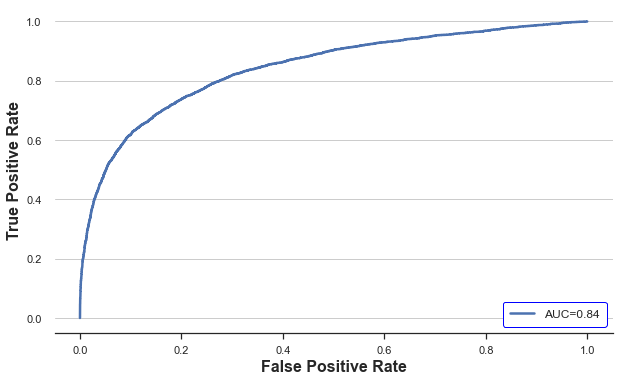

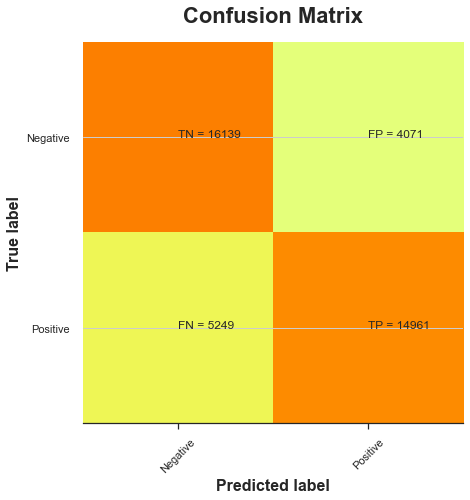


Classification report

              precision    recall  f1-score   support

         0.0       0.75      0.80      0.78     20210
         1.0       0.79      0.74      0.76     20210

    accuracy                           0.77     40420
   macro avg       0.77      0.77      0.77     40420
weighted avg       0.77      0.77      0.77     40420


_________________________________________

Specificity

0.8

_________________________________________


In [53]:
# defining pipe again just to make verbose=2 in the model
d_in = len(X_train.iloc[0])

# pipe = Pipeline(steps=[
# ('resample', upsampler()),
# ('scaler', MinMaxScaler()),
# ('imputer',IterativeImputer(max_iter=10, random_state=42, missing_values=np.nan)),
# ('model', tabular_nn_model(d_in=d_in, n_epochs=100, lr=0.01, weight_decay=0, early_stop=True, verbose=2))
# ])


# manual params setting
best_params2 = {'model__lr': 0.01, 'model__drop_out': 0.4}

            
# best_params2 = best_params

sample_ratio = 1
n_samples = int(len(X_train)*sample_ratio)
X, y = resample(X_train.values, y_train.values, n_samples=n_samples, stratify=y_train.values, random_state=10)
model_final = copy.deepcopy(pipe)
model_final.set_params(**best_params2)
model_final.fit(X, y.ravel());


print("")
print("")
print("_"*150)
print("")
print("Train Accuracy:")
print("")

y_pred = model_final.predict(X)
y_pred_proba = model_final.predict_proba(X)

confusion_matrix_plot(y, y_pred, y_pred_proba)




# dump(model_final, open('pipe_rf.pkl', 'wb'))


__________
### Test accuracy

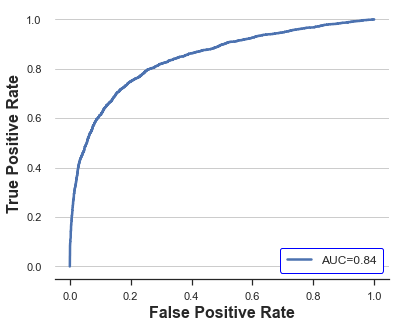

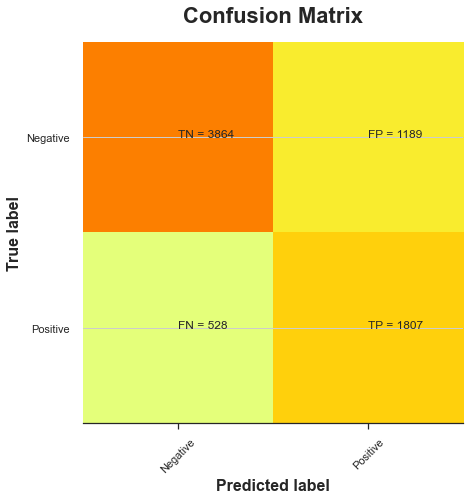


Classification report

              precision    recall  f1-score   support

         0.0       0.88      0.76      0.82      5053
         1.0       0.60      0.77      0.68      2335

    accuracy                           0.77      7388
   macro avg       0.74      0.77      0.75      7388
weighted avg       0.79      0.77      0.77      7388


_________________________________________

Specificity

0.76

_________________________________________


In [62]:

# X,y = model_final.named_steps['resample'].fit_resample(X_test, y_test)
plt.rcParams["figure.figsize"] = (6,5)

X,y = X_test.values, y_test.values

y_pred = model_final.predict(X)
y_pred_proba = model_final.predict_proba(X)
y_pred  = (y_pred_proba[:,1] >= 0.65).astype(int)

confusion_matrix_plot(y, y_pred, y_pred_proba)


In [55]:
df_y.value_counts()

outcome
0.0        25263
1.0        11676
dtype: int64

In [58]:
fpr_ANN_grade123, tpr_ANN_grade123, _ = metrics.roc_curve(y,   y_pred_proba[::,1])
%store fpr_ANN_grade123
%store tpr_ANN_grade123

Stored 'fpr_ANN_grade123' (ndarray)
Stored 'tpr_ANN_grade123' (ndarray)


In [56]:
RF_model = model_final._final_estimator

In [57]:
importances = RF_model.feature_importances_
indices = np.argsort(importances)

features = X_train.columns
plt.rcParams["figure.figsize"] = (12,15)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

AttributeError: 'tabular_nn_model' object has no attribute 'feature_importances_'

## SHAP

In [ ]:
import shap

X_test_imputed_array = model_final.named_steps['imputer'].transform(X_test)
X_test_imputed = pd.DataFrame(X_test_imputed_array, columns=X_test.columns)
X_test_scaled_array = model_final.named_steps['scaler'].transform(X_test_imputed)
df_test_imputed_scaled = pd.DataFrame(X_test_scaled_array, columns=X_test.columns)

shap.initjs()
explainer = shap.TreeExplainer(RF_model)
shap_values = explainer.shap_values(df_test_imputed_scaled)

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
y_test.query("outcome==1").iloc[[40]]

In [ ]:
row_numbers = y_test.loc[31703381,19338519,20471295].index

In [ ]:
len(row_numbers)

In [ ]:
row_number_1 = 402
row = df_test_imputed_scaled.iloc[[row_number_1]]
row

In [ ]:
y_test[y_test["outcome"]==1]

In [ ]:
y_test.iloc[[row_number_1]]

In [ ]:
val = RF_model.predict_proba(df_test_imputed_scaled.iloc[[row_number_1]])
val

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1][[row_number_1]], df_test_imputed_scaled.iloc[[row_number_1]])

In [ ]:
shap.waterfall_plot(explainer.expected_value[1],shap_values[1][[row_number_1]])

## Histograms

In [ ]:
# combining X_test,y_test and y_pred in one dataset
# del(df_test_all)
df_test_all = X_test.copy()
df_test_all['y_actual'] = y_test
df_test_all['y_pred'] = y_pred
# df_test_all

In [ ]:
# labeling the category of error

pd.options.mode.chained_assignment = None  # To suppress a warning for commands below 

df_test_all['error_category'] = 0 # create'error_category' column
for i in df_test_all.index:
     if df_test_all['y_actual'][i] == 0 and df_test_all['y_pred'][i] == 0: # True negative 0 
          df_test_all['error_category'][i] = 0
     if df_test_all['y_actual'][i] == 0 and df_test_all['y_pred'][i] == 1: # False positive 1
          df_test_all['error_category'][i] = 1
     if df_test_all['y_actual'][i] == 1 and df_test_all['y_pred'][i] == 1: # True positive 2
          df_test_all['error_category'][i] = 2
     if df_test_all['y_actual'][i] == 1 and df_test_all['y_pred'][i] == 0: # False negative 3
          df_test_all['error_category'][i] = 3

# df_test_all

In [ ]:
df_TN = df_test_all[df_test_all.error_category==0]
df_FP = df_test_all[df_test_all.error_category==1]

df_TP = df_test_all[df_test_all.error_category==2]
df_FN = df_test_all[df_test_all.error_category==3]

In [ ]:
df_FP.shape

In [ ]:
#Merge the DataFrames
common_FP = pd.merge(df_FP, processed, how='inner', left_index=True, right_index=True, suffixes=('', '_drop'))

#Drop the duplicate columns
common_FP.drop([col for col in common_FP.columns if 'drop' in col], axis=1, inplace=True)


#Merge the DataFrames
common_TN = pd.merge(df_TN, processed, how='inner', left_index=True, right_index=True, suffixes=('', '_drop'))

#Drop the duplicate columns
common_TN.drop([col for col in common_TN.columns if 'drop' in col], axis=1, inplace=True)

#Merge the DataFrames
common_TP = pd.merge(df_TP, processed, how='inner', left_index=True, right_index=True, suffixes=('', '_drop'))

#Drop the duplicate columns
common_TP.drop([col for col in common_TP.columns if 'drop' in col], axis=1, inplace=True)


#Merge the DataFrames
common_FN = pd.merge(df_FN, processed, how='inner', left_index=True, right_index=True, suffixes=('', '_drop'))

#Drop the duplicate columns
common_FN.drop([col for col in common_FN.columns if 'drop' in col], axis=1, inplace=True)


#Merge the DataFrames
common_test_all = pd.merge(df_test_all, processed, how='inner', left_index=True, right_index=True, suffixes=('', '_drop'))

#Drop the duplicate columns
common_test_all.drop([col for col in common_test_all.columns if 'drop' in col], axis=1, inplace=True)

In [ ]:
import seaborn as sns
sns.jointplot(x="egfr_epi_scr", y="age", data=common_FP, kind="hex", joint_kws={'color':'#66ffcc'})
plt.axvline(60, 0,10, linestyle='--', color = 'red', linewidth=1.5)
plt.axvline(90, 0,10, linestyle='--', color = 'red', linewidth=1.5)


In [ ]:
(common_FP[common_FP.egfr_epi_scr<90].shape[0])/(common_FP.shape[0])

In [ ]:
import seaborn as sns
sns.jointplot(x="egfr_epi_scr", y="age", data=common_TN, kind="hex", joint_kws={'color':"#66ffcc"})
plt.axvline(60, 0,10, linestyle='--', color = 'red', linewidth=1.5)
plt.axvline(90, 0,10, linestyle='--', color = 'red', linewidth=1.5)

In [ ]:
(common_TN[common_TN.egfr_epi_scr<90].shape[0])/(common_TN.shape[0])

In [ ]:
import seaborn as sns
sns.jointplot(x="egfr_epi_scr", y="age", data=common_TP, kind="hex", joint_kws={'color':"#66ffcc"})
plt.axvline(60, 0,10, linestyle='--', color = 'red', linewidth=1.5)
plt.axvline(90, 0,10, linestyle='--', color = 'red', linewidth=1.5)

In [ ]:
import seaborn as sns
sns.jointplot(x="egfr_epi_scr", y="age", data=common_FN, kind="hex", joint_kws={'color':"#66ffcc"})
plt.axvline(60, 0,10, linestyle='--', color = 'red', linewidth=1.5)
plt.axvline(90, 0,10, linestyle='--', color = 'red', linewidth=1.5)

In [ ]:
import seaborn as sns

plt.rcParams["figure.figsize"] = (10,6)
plt.axvline(90, 0,10, linestyle='--', color = 'red', linewidth=1.5)
sns.histplot(data=common_FP, x=common_FP.egfr_epi_scr, common_norm=False, bins=50, stat="percent");
plt.title("Kernel Density Function");

In [ ]:
import seaborn as sns

plt.axvline(90, 0,10, linestyle='--', color = 'red', linewidth=1.5)
plt.rcParams["figure.figsize"] = (10,6)
sns.histplot(data=common_FP, x=common_FP.egfr_epi_scr, hue='age', common_norm=False, bins=50, stat="percent");
plt.title("Kernel Density Function");

In [ ]:
# Creating bins
x_min = np.min(common_FP.egfr_epi_scr)
x_max = np.max(common_FP.egfr_epi_scr)
  
y_min = np.min(common_FP.age)
y_max = np.max(common_FP.age)
  
x_bins = np.linspace(x_min, x_max, 50)
y_bins = np.linspace(y_min, y_max, 20)

fig, ax = plt.subplots(figsize =(10, 7))
plt.hist2d(common_FP.egfr_epi_scr, common_FP.age, bins=[x_bins, y_bins])
plt.axvline(90, 0,10, linestyle='--', color = 'blue', linewidth=1.5)
plt.title("2D histogram of false positives")
ax.set_xlabel('minimum EGFR') 
ax.set_ylabel('Age') 

# show plot
plt.tight_layout() 
plt.show()

In [ ]:
# Creating bins
x_min = np.min(common_FP.egfr_epi_scr)
x_max = np.max(common_FP.egfr_epi_scr)
  
y_min = np.min(common_FP.age)
y_max = np.max(common_FP.age)
  
x_bins = np.linspace(x_min, x_max, 50)
y_bins = np.linspace(y_min, y_max, 20)

fig, ax = plt.subplots(figsize =(10, 7))
plt.hexbin(common_FP.egfr_epi_scr, common_FP.age, bins=50)
plt.axvline(90, 0,10, linestyle='--', color = 'blue', linewidth=1.5)
plt.title("2D histogram of false positives")
ax.set_xlabel('minimum EGFR') 
ax.set_ylabel('Age') 

# show plot
plt.tight_layout() 
plt.show()

In [ ]:
for i, col in enumerate(common_FP.columns):
    plt.figure(i)
    sns.histplot(data=common_FP, x=col, bins=50, stat='percent', common_norm=False);
    plt.title(col);

In [ ]:
df_test_all['error_category'] = 0 # create'error_category' column
for i in df_test_all.index:
     if df_test_all['y_actual'][i] == 0 and df_test_all['y_pred'][i] == 0: # True negative 0 
          df_test_all['error_category'][i] = 0
     if df_test_all['y_actual'][i] == 0 and df_test_all['y_pred'][i] == 1: # False positive 1
          df_test_all['error_category'][i] = 1

In [ ]:
# get data for True negative and  False positive and compare their distribution.
# It plots the distribution and prints Jensen-Shanon distance.
# from functions_compare_distribution import compare_hist_df
from dfwiz import dfwiz, dfwiz_compare
# healthy patients
TN = df_test_all.query("error_category == 0")[X_test.columns] # True negative
FP = df_test_all.query("error_category == 1")[X_test.columns] # False positive

if len(TN) == 0 or len(FP) == 0:
    print("Error! one of the dataframes are empty")
else:
    # compare_hist_df(TN, FP) # plot distributions and output Jensen-Shanon distance.
    dfwiz_compare(FP, TN,label=['FP', 'TN'])

In [ ]:
for i, col in enumerate(df_test_all.columns):
    plt.figure(i)
    sns.kdeplot(data=df_test_all, x=col, hue='error_category', bins=50, stat='density', common_norm=False);
    plt.title(col);

In [ ]:
for i, col in enumerate(df_test_all.columns):
    plt.figure(i)
    sns.histplot(data=df_test_all, x=col, hue='error_category', common_norm=False, bins=50, stat="percent");
    plt.title("Kernel Density Function");

In [ ]:
sns.histplot(data=df_FP, x=df_FP.egfr_epi_scr, hue='age', common_norm=False, bins=50, stat="density");
plt.title("Kernel Density Function");

In [ ]:
for i, col in enumerate(df_test_all.columns):
    plt.figure(i)
    sns.histplot(data=df_test_all, x=col, hue='error_category', bins=len(df_test_all), stat='density', element="step", fill=False, cumulative=True,common_norm=False);
    plt.title("Cumulative distribution function");

## Decision Tree on validation set to differentiate between 

In [ ]:
# labeling the category of error
# del(df_test_all)

# X_valid_imputed_array = model_final.named_steps['imputer'].transform(X_valid)
X_valid_imputed_array = model_final.named_steps['imputer'].transform(X_train)
X_valid_imputed = pd.DataFrame(X_valid_imputed_array, columns=X_valid.columns)
X_valid_scaled_array = model_final.named_steps['scaler'].transform(X_valid_imputed)
df_test_all = pd.DataFrame(X_valid_scaled_array, columns=X_valid.columns)


# df_test_all['y_actual'] = y_valid.values.ravel()
df_test_all['y_actual'] = y_train.values.ravel()
df_test_all['y_pred'] = y_pred

pd.options.mode.chained_assignment = None  # To suppress a warning for commands below 

df_test_all['error_category'] = 0 # create'error_category' column
for i in df_test_all.index:
     if df_test_all['y_actual'][i] == 0 and df_test_all['y_pred'][i] == 0: # True negative 0 
          df_test_all['error_category'][i] = 0
     if df_test_all['y_actual'][i] == 0 and df_test_all['y_pred'][i] == 1: # False positive 1
          df_test_all['error_category'][i] = 1
     if df_test_all['y_actual'][i] == 1 and df_test_all['y_pred'][i] == 1: # True positive 2
          df_test_all['error_category'][i] = 2
     if df_test_all['y_actual'][i] == 1 and df_test_all['y_pred'][i] == 0: # False negative 3
          df_test_all['error_category'][i] = 3

In [ ]:
# train a descision tree to predict the model error in negative cases ('True negative' vs 'False positive'). 
from sklearn import tree


class_names = ['TN', 'FP', 'TP', 'FN' ]
df1 = df_test_all.copy()
X1 = df1[X_test.columns]
X1
y1 =  df1[['error_category']]
clf = tree.DecisionTreeClassifier(max_depth = 5 , class_weight='balanced', random_state=42, criterion="gini", min_impurity_decrease = 0.002)
clf = clf.fit(X1, y1)

# plot the tree
plt.figure(figsize=(20,12))
tree.plot_tree(clf,
               feature_names = list(X1.columns), 
               rounded=True, 
               filled = True,
               proportion = True,
               class_names = class_names);


In [ ]:
# X_train_imputed_array = model_final.named_steps['imputer'].transform(X_train)
# X_train_imputed = pd.DataFrame(X_train_imputed_array, columns=X_train.columns)
# X_train_scaled_array = model_final.named_steps['scaler'].transform(X_train_imputed)
# X_train_imputed = pd.DataFrame(X_train_scaled_array, columns=X_train.columns)


# X_valid_imputed_array = model_final.named_steps['imputer'].transform(X_valid)
# X_valid_imputed = pd.DataFrame(X_valid_imputed_array, columns=X_valid.columns)
# X_valid_scaled__array = model_final.named_steps['scaler'].transform(X_valid_imputed)
# X_valid_imputed = pd.DataFrame(X_valid_scaled__array, columns=X_valid.columns)

# y_error_t = clf.predict(X_train_imputed)
# y_error_v = clf.predict(X_valid_imputed)

# # True Negatives (0)
# X_train_TN = X_train.loc[(y_error_t==0)]
# y_train_TN = y_train.loc[(y_error_t==0)]

# X_valid_TN = X_valid.loc[(y_error_v==0)]
# y_valid_TN = y_valid.loc[(y_error_v==0)]

# # False Positives (1)
# X_train_FP = X_train.loc[(y_error_t==1)]
# y_train_FP = y_train.loc[(y_error_t==1)]

# X_valid_FP = X_valid.loc[(y_error_v==1)]
# y_valid_FP = y_valid.loc[(y_error_v==1)]

# # True Positives (2)
# X_train_TP = X_train.loc[(y_error_t==2)]
# y_train_TP = y_train.loc[(y_error_t==2)]

# X_valid_TP = X_valid.loc[(y_error_v==2)]
# y_valid_TP = y_valid.loc[(y_error_v==2)]

# # False Negatives (3)
# X_train_FN = X_train.loc[(y_error_t==3)]
# y_train_FN = y_train.loc[(y_error_t==3)]

# X_valid_FN = X_valid.loc[(y_error_v==3)]
# y_valid_FN = y_valid.loc[(y_error_v==3)]


In [ ]:
X_train_imputed_array = model_final.named_steps['imputer'].transform(X_train)
X_train_imputed = pd.DataFrame(X_train_imputed_array, columns=X_train.columns)
X_train_scaled_array = model_final.named_steps['scaler'].transform(X_train_imputed)
X_train_imputed = pd.DataFrame(X_train_scaled_array, columns=X_train.columns)


X_test_imputed_array = model_final.named_steps['imputer'].transform(X_test)
X_test_imputed = pd.DataFrame(X_test_imputed_array, columns=X_test.columns)
X_test_scaled_array = model_final.named_steps['scaler'].transform(X_test_imputed)
X_test_imputed = pd.DataFrame(X_test_scaled_array, columns=X_test.columns)

y_error_t = model_final.predict(X_train_imputed)
y_error_v = model_final.predict(X_test_imputed)

# True Negatives (0)
X_train_TN = X_train.loc[(y_error_t==0)]
y_train_TN = y_train.loc[(y_error_t==0)]

X_valid_TN = X_test.loc[(y_error_v==0)]
y_valid_TN = y_test.loc[(y_error_v==0)]

# False Positives (1)
X_train_FP = X_train.loc[(y_error_t==1)]
y_train_FP = y_train.loc[(y_error_t==1)]

X_valid_FP = X_test.loc[(y_error_v==1)]
y_valid_FP = y_test.loc[(y_error_v==1)]

# True Positives (2)
X_train_TP = X_train.loc[(y_error_t==2)]
y_train_TP = y_train.loc[(y_error_t==2)]

X_valid_TP = X_test.loc[(y_error_v==2)]
y_valid_TP = y_test.loc[(y_error_v==2)]

# False Negatives (3)
X_train_FN = X_train.loc[(y_error_t==3)]
y_train_FN = y_train.loc[(y_error_t==3)]

X_valid_FN = X_test.loc[(y_error_v==3)]
y_valid_FN = y_test.loc[(y_error_v==3)]

In [ ]:
y_valid_FP.value_counts()

In [ ]:
X_train_new = X_train.loc[~(y_error_t==1)]
y_train_new = y_train.loc[~(y_error_t==1)]

X_valid_new = X_valid.loc[~(y_error_v==1)]
y_valid_new = y_valid.loc[~(y_error_v==1)]

In [ ]:
# X_train_new, y_train_new = up_sample(X_train_new, y_train_new,'outcome')
X_train_new, y_train_new = up_sample(X_train, y_train,'outcome')

In [ ]:
# manual params setting
# best_params2 = {'model__n_estimators':300,'model__max_depth': 40
# ,'model__min_samples_leaf': 0.1, 'model__min_samples_split': 0.1}

best_params2 = {'model__n_estimators':100,'model__max_depth': 50
,'model__min_samples_leaf': 350, 'model__min_samples_split': 350}


# Or get parameters from search above
# best_params2 = best_params

sample_ratio = 1
n_samples = int(len(X_train_new)*sample_ratio)
X, y = resample(X_train_new.values, y_train_new.values, n_samples=n_samples, stratify=y_train_new.values, random_state=10)
model_final = copy.deepcopy(pipe)
model_final.set_params(**best_params2)
model_final.fit(X, y.ravel());


print("")
print("")
print("_"*150)
print("")
print("Train Accuracy:")
print("")

y_pred = model_final.predict(X)
y_pred_proba = model_final.predict_proba(X)

confusion_matrix_plot(y, y_pred, y_pred_proba)




# dump(model_final, open('pipe_rf.pkl', 'wb'))


In [ ]:

# X,y = model_final.named_steps['resample'].fit_resample(X_test, y_test)
X,y = X_valid_new.values, y_valid_new.values

# X,y = X_test.values, y_test.values

y_pred = model_final.predict(X)
y_pred_proba = model_final.predict_proba(X)
y_pred  = (y_pred_proba[:,1] >= 0.6).astype(int)

confusion_matrix_plot(y, y_pred, y_pred_proba)


In [ ]:
importances = clf.feature_importances_
indices = np.argsort(importances)

features = X_train.columns
plt.rcParams["figure.figsize"] = (12,20)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
df_valid_RF = df_test_all.copy()
y = df_valid_RF.error_category
y

In [ ]:
# import lightgbm as lgbm  # standard alias

# pipe = Pipeline(steps=[
# ('resample', upsampler()),
# ('scaler', MinMaxScaler()),
# ('imputer',IterativeImputer(max_iter=10, random_state=42, missing_values=np.nan)),
# ('model', lgbm.LGBMClassifier(n_jobs=-1, n_estimators=300))
# ])

RF to classify 4 error categories

In [ ]:
########### **************************************8
# Make sure simpler models are at the start of array. The search picks numbers on the left side if they are within the error of maximum score.   
# param_grid ={'model__num_leaves': [6, 10, 20, 50], 
#              'model__min_child_samples': [100, 200, 300, 400, 500], 
#              'model__min_child_weight': [1e-5,  1e-2,  1,  1e2,  1e4],
#              'model__subsample' : [0.2, 0.5, 0.8], 
#              'model__reg_alpha': [0, 1e-1, 1, 5,  10, 50, 100],
#              'model__reg_lambda': [0, 1e-1, 1,  10,  50, 100]}

param_grid = {
    'model__n_estimators': [100, 500 ],
    'model__max_depth': [ 30 , 40, 50 , 60 , 80, 100],
    'model__min_samples_leaf': [100, 70, 50,20, 10,5],
    'model__min_samples_split' : [100, 70, 50,20, 10,5]
}

# param_grid ={'model__max_depth': [6, 10], 
#    }
df_valid_RF = df_test_all.copy()
y = df_valid_RF.error_category
X = df_valid_RF.drop(['y_actual','y_pred','error_category'], axis=1)



score, best_params, model_final = param_graph(X, y, pipe, param_grid, cv=5, max_iter = 4, sample_ratio = 0.1, refit=False, use_error=True, multi_class=True, average_metric="micro")

# dump(model_final , open('model_final_LGBM.pkl', 'wb'))

In [ ]:
# train a descision tree to predict the model error in negative cases ('True negative' vs 'False positive'). 
from sklearn.ensemble import RandomForestClassifier


class_names = ['TN', 'FP', 'TP', 'FN' ]
df1 = df_test_all.copy()
X1 = df1[X_valid.columns]
y1 =  df1[['error_category']]
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf = clf.fit(X1, y1)

# plot the tree
# plt.figure(figsize=(20,12))
# tree.plot_tree(clf,
#                feature_names = list(X1.columns), 
#                rounded=True, 
#                filled = True,
#                proportion = True,
#                class_names = class_names);

from sklearn.metrics import multilabel_confusion_matrix,plot_confusion_matrix
# cm = multilabel_confusion_matrix(y1, y_pred)
plot_confusion_matrix(clf, X1, y1, display_labels=['TN','FP','TP','FN'])
plt.show()


In [ ]:
X_train_imputed_array = model_final.named_steps['imputer'].transform(X_test)
X_train_imputed = pd.DataFrame(X_train_imputed_array, columns=X_train.columns)
X_train_scaled_array = model_final.named_steps['scaler'].transform(X_train_imputed)
X_test_imputed_scaled = pd.DataFrame(X_train_scaled_array, columns=X_test.columns)

y_pred2 =clf.predict(X_test_imputed_scaled)
# plot_confusion_matrix(clf, X_test, y_test, display_labels=['TN','FP','TP','FN'])
# plt.show()

In [ ]:
y_pred3 = np.where((y_pred2==0) | (y_pred2==2),1,0)

In [ ]:
np.where(y_pred3==1)

In [ ]:
# from sklearn.metrics import multilabel_confusion_matrix,plot_confusion_matrix


# best_params2 = {'model__n_estimators':100,'model__max_depth': 80
# ,'model__min_samples_leaf': 50, 'model__min_samples_split': 50}


# df_valid_RF = df_test_all.copy()
# y = df_valid_RF.error_category
# X = df_valid_RF.drop(['y_actual','y_pred','error_category'], axis=1)



# sample_ratio = 1
# n_samples = int(len(X)*sample_ratio)
# X, y = resample(X, y, n_samples=n_samples, stratify=y, random_state=10)
# model_RF_error_cat = copy.deepcopy(pipe)
# model_RF_error_cat.set_params(**best_params2)
# model_RF_error_cat.fit(X, y.ravel());


# print("")
# print("")
# print("_"*150)
# print("")
# print("Train Accuracy:")
# print("")

# y_pred = model_RF_error_cat.predict(X)
# y_pred_proba = model_RF_error_cat.predict_proba(X)

# cm = multilabel_confusion_matrix(y, y_pred)
# plot_confusion_matrix(model_RF_error_cat, X, y, display_labels=['TN','FP','TP','FN'])
# plt.show()


# # display_labels=['TN','FP','TP','FN']

In [ ]:
clf.classes_

In [ ]:
y1.value_counts()

In [ ]:
X_train_imputed_array = model_final.named_steps['imputer'].transform(X_train)
X_train_imputed = pd.DataFrame(X_train_imputed_array, columns=X_train.columns)
X_train_scaled_array = model_final.named_steps['scaler'].transform(X_train_imputed)
X_train_imputed_scaled = pd.DataFrame(X_train_scaled_array, columns=X_train.columns)


X_valid_imputed_array = model_final.named_steps['imputer'].transform(X_valid)
X_valid_imputed = pd.DataFrame(X_valid_imputed_array, columns=X_valid.columns)
X_valid_scaled__array = model_final.named_steps['scaler'].transform(X_valid_imputed)
X_valid_imputed_scaled = pd.DataFrame(X_valid_scaled__array, columns=X_valid.columns)


y_error_t = clf.predict(X_train_imputed_scaled)
y_error_v = clf.predict(X_valid_imputed_scaled)

# True Negatives (0)
X_train_TN = X_train.loc[(y_error_t==0)]
y_train_TN = y_train.loc[(y_error_t==0)]

X_valid_TN = X_valid.loc[(y_error_v==0)]
y_valid_TN = y_valid.loc[(y_error_v==0)]

# False Positives (1)
X_train_FP = X_train.loc[(y_error_t==1)]
y_train_FP = y_train.loc[(y_error_t==1)]

X_valid_FP = X_valid.loc[(y_error_v==1)]
y_valid_FP = y_valid.loc[(y_error_v==1)]

# True Positives (2)
X_train_TP = X_train.loc[(y_error_t==2)]
y_train_TP = y_train.loc[(y_error_t==2)]

X_valid_TP = X_valid.loc[(y_error_v==2)]
y_valid_TP = y_valid.loc[(y_error_v==2)]

# False Negatives (3)
X_train_FN = X_train.loc[(y_error_t==3)]
y_train_FN = y_train.loc[(y_error_t==3)]

X_valid_FN = X_valid.loc[(y_error_v==3)]
y_valid_FN = y_valid.loc[(y_error_v==3)]


In [ ]:
np.where(y_error_v==3)
# y_valid_TP.value_counts()

In [ ]:
len(np.where(y_error_v==1)[0])

In [ ]:
y_valid_FN.value_counts()

In [ ]:
# X_train_True, y_train_True = up_sample(X_train_True, y_train_True,'outcome')
# X_train_False, y_train_False = up_sample(X_train_False, y_train_False,'outcome')

## TN estimator

In [ ]:
# manual params setting
# best_params2 = {'model__n_estimators':300,'model__max_depth': 40
# ,'model__min_samples_leaf': 0.1, 'model__min_samples_split': 0.1}

best_params2 = {'model__n_estimators':100,'model__max_depth': 50
,'model__min_samples_leaf': 250, 'model__min_samples_split': 250}


# Or get parameters from search above
# best_params2 = best_params

sample_ratio = 1
n_samples = int(len(X_train_TN)*sample_ratio)
X, y = resample(X_train_TN.values, y_train_TN.values, n_samples=n_samples, stratify=y_train_TN.values, random_state=10)
model_final_TN = copy.deepcopy(pipe)
model_final_TN.set_params(**best_params2)
model_final_TN.fit(X, y.ravel());


print("")
print("")
print("_"*150)
print("")
print("Train Accuracy:")
print("")

y_pred = model_final_TN.predict(X)
y_pred_proba = model_final_TN.predict_proba(X)

confusion_matrix_plot(y, y_pred, y_pred_proba)




# dump(model_final, open('pipe_rf.pkl', 'wb'))


In [ ]:
y_train_FP.value_counts()

In [ ]:

# X,y = model_final.named_steps['resample'].fit_resample(X_test, y_test)
X,y = X_valid_TN.values, y_valid_TN.values

# y_pred = model_final.predict(X)
y_pred_proba = model_final_TN.predict_proba(X)
y_pred  = (y_pred_proba[:,1] >= 0.4).astype(int)

confusion_matrix_plot(y, y_pred, y_pred_proba)


## FP estimator

In [ ]:
# manual params setting
# best_params2 = {'model__n_estimators':300,'model__max_depth': 40
# ,'model__min_samples_leaf': 0.1, 'model__min_samples_split': 0.1}

best_params2 = {'model__n_estimators':100,'model__max_depth': 40
,'model__min_samples_leaf': 50, 'model__min_samples_split': 50}


# Or get parameters from search above
# best_params2 = best_params

sample_ratio = 1
n_samples = int(len(X_train_FP)*sample_ratio)
X, y = resample(X_train_FP.values, y_train_FP.values, n_samples=n_samples, stratify=y_train_FP.values, random_state=10)
model_final_FP = copy.deepcopy(pipe)
model_final_FP.set_params(**best_params2)
model_final_FP.fit(X, y.ravel());


print("")
print("")
print("_"*150)
print("")
print("Train Accuracy:")
print("")

y_pred = model_final_FP.predict(X)
y_pred_proba = model_final_FP.predict_proba(X)

confusion_matrix_plot(y, y_pred, y_pred_proba)




# dump(model_final, open('pipe_rf.pkl', 'wb'))


In [ ]:

# X,y = model_final.named_steps['resample'].fit_resample(X_test, y_test)
X,y = X_valid_FP.values, y_valid_FP.values

# y_pred = model_final.predict(X)
y_pred_proba = model_final_FP.predict_proba(X)
y_pred  = (y_pred_proba[:,1] >= 0.4).astype(int)

confusion_matrix_plot(y, y_pred, y_pred_proba)


## TP estimator

In [ ]:
# manual params setting
# best_params2 = {'model__n_estimators':300,'model__max_depth': 40
# ,'model__min_samples_leaf': 0.1, 'model__min_samples_split': 0.1}

best_params2 = {'model__n_estimators':100,'model__max_depth': 50
,'model__min_samples_leaf': 150, 'model__min_samples_split': 150}


# Or get parameters from search above
# best_params2 = best_params

sample_ratio = 1
n_samples = int(len(X_train_TP)*sample_ratio)
X, y = resample(X_train_TP.values, y_train_TP.values, n_samples=n_samples, stratify=y_train_TP.values, random_state=10)
model_final_TP = copy.deepcopy(pipe)
model_final_TP.set_params(**best_params2)
model_final_TP.fit(X, y.ravel());


print("")
print("")
print("_"*150)
print("")
print("Train Accuracy:")
print("")

y_pred = model_final_TP.predict(X)
y_pred_proba = model_final_TP.predict_proba(X)

confusion_matrix_plot(y, y_pred, y_pred_proba)




# dump(model_final, open('pipe_rf.pkl', 'wb'))


In [ ]:
X_train_TP.value_counts()

In [ ]:

# X,y = model_final.named_steps['resample'].fit_resample(X_test, y_test)
X,y = X_valid_TP.values, y_valid_TP.values

# y_pred = model_final.predict(X)
y_pred_proba = model_final_TP.predict_proba(X)
y_pred  = (y_pred_proba[:,1] >= 0.4).astype(int)

confusion_matrix_plot(y, y_pred, y_pred_proba)


## FN estimitor

In [ ]:
# manual params setting
# best_params2 = {'model__n_estimators':300,'model__max_depth': 40
# ,'model__min_samples_leaf': 0.1, 'model__min_samples_split': 0.1}

best_params2 = {'model__n_estimators':100,'model__max_depth': 50
,'model__min_samples_leaf': 250, 'model__min_samples_split': 250}


# Or get parameters from search above
# best_params2 = best_params

sample_ratio = 1
n_samples = int(len(X_train_FN)*sample_ratio)
X, y = resample(X_train_FN.values, y_train_FN.values, n_samples=n_samples, stratify=y_train_FN.values, random_state=10)
model_final_FN = copy.deepcopy(pipe)
model_final_FN.set_params(**best_params2)
model_final_FN.fit(X, y.ravel());


print("")
print("")
print("_"*150)
print("")
print("Train Accuracy:")
print("")

y_pred = model_final_FN.predict(X)
y_pred_proba = model_final_FN.predict_proba(X)

confusion_matrix_plot(y, y_pred, y_pred_proba)




# dump(model_final, open('pipe_rf.pkl', 'wb'))


In [ ]:

# X,y = model_final.named_steps['resample'].fit_resample(X_test, y_test)
X,y = X_valid_FN.values, y_valid_FN.values

# y_pred = model_final.predict(X)
y_pred_proba = model_final_FN.predict_proba(X)
y_pred  = (y_pred_proba[:,1] >= 0.4).astype(int)

confusion_matrix_plot(y, y_pred, y_pred_proba)


In [ ]:
X,y = X_test, y_test

y_pred_proba_list = []
for i in range(len(X)):
    # X_imputed = model_final.named_steps['imputer'].transform(X.iloc[[i]])
    X_valid_imputed_array = model_final.named_steps['imputer'].transform(X.iloc[[i]])
    X_valid_imputed = pd.DataFrame(X_valid_imputed_array, columns=X_valid.columns)
    X_valid_scaled_array = model_final.named_steps['scaler'].transform(X_valid_imputed)
    df_test_all = pd.DataFrame(X_valid_scaled_array, columns=X_valid.columns)
    tree_predict = clf.predict(df_test_all)
    if(tree_predict == 0): #TN
        y_pred_proba_list.insert(i, list(model_final_TN.predict_proba(X.iloc[[i]])[0]))
    elif(tree_predict == 1): #FP
        y_pred_proba_list.insert(i, list(model_final_FP.predict_proba(X.iloc[[i]])[0]))
    elif(tree_predict == 2): #TP
        y_pred_proba_list.insert(i, list(model_final_TP.predict_proba(X.iloc[[i]])[0]))
    elif(tree_predict == 3): #FN
        y_pred_proba_list.insert(i, list(model_final_FN.predict_proba(X.iloc[[i]])[0]))

y_pred_proba = np.array(y_pred_proba_list)


In [ ]:
y_pred  = (y_pred_proba[:,1] >= 0.4).astype(int)

confusion_matrix_plot(y, y_pred, y_pred_proba)

In [ ]:
df_test_all['error_category'] = 0 # create'error_category' column
for i in df_test_all.index:
     if df_test_all['y_actual'][i] == 0 and df_test_all['y_pred'][i] == 0: # True negative 0 
          df_test_all['error_category'][i] = 0
     if df_test_all['y_actual'][i] == 0 and df_test_all['y_pred'][i] == 1: # False positive 1
          df_test_all['error_category'][i] = 1
     if df_test_all['y_actual'][i] == 1 and df_test_all['y_pred'][i] == 1: # True positive 2
          df_test_all['error_category'][i] = 2
     if df_test_all['y_actual'][i] == 1 and df_test_all['y_pred'][i] == 0: # False negative 3
          df_test_all['error_category'][i] = 3